### Prepare Data for sweep speed

In [22]:
import os
import shutil

def modify_input_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    new_lines = []
    for line in lines:
        if line.strip().startswith("H2O") and "; 0;" in line:
            new_lines.append("H2O            ; 0; 1\n")
        elif line.strip().startswith("CO") and "; 0;" in line:
            new_lines.append("CO             ; 0; 0.016\n")
        elif line.strip().startswith("PRESSURE"):
            new_lines.append("PRESSURE = -1\n")
        else:
            new_lines.append(line)

    with open(file_path, 'w') as f:
        f.writelines(new_lines)

def clean_directory(directory, keep_file='input_file.mkm'):
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        if os.path.basename(item_path) == keep_file:
            continue
        if os.path.isfile(item_path):
            os.remove(item_path)
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)

def process_all_directories(base_path):
    for root, dirs, files in os.walk(base_path):
        if 'input_file.mkm' in files:
            input_path = os.path.join(root, 'input_file.mkm')
            print(f"Processing: {input_path}")
            modify_input_file(input_path)
            clean_directory(root)

# Use your base directory path here
base_dir = r'D:\projects\new_calculation\corr\sweeping\USS_CV\CORR\Steady_state\pH_7'
process_all_directories(base_dir)


Processing: D:\projects\new_calculation\corr\sweeping\USS_CV\CORR\Steady_state\pH_7\V_-0.1\input_file.mkm
Processing: D:\projects\new_calculation\corr\sweeping\USS_CV\CORR\Steady_state\pH_7\V_-0.2\input_file.mkm
Processing: D:\projects\new_calculation\corr\sweeping\USS_CV\CORR\Steady_state\pH_7\V_-0.3\input_file.mkm
Processing: D:\projects\new_calculation\corr\sweeping\USS_CV\CORR\Steady_state\pH_7\V_-0.4\input_file.mkm
Processing: D:\projects\new_calculation\corr\sweeping\USS_CV\CORR\Steady_state\pH_7\V_-0.5\input_file.mkm
Processing: D:\projects\new_calculation\corr\sweeping\USS_CV\CORR\Steady_state\pH_7\V_-0.6\input_file.mkm
Processing: D:\projects\new_calculation\corr\sweeping\USS_CV\CORR\Steady_state\pH_7\V_-0.7\input_file.mkm
Processing: D:\projects\new_calculation\corr\sweeping\USS_CV\CORR\Steady_state\pH_7\V_-0.8\input_file.mkm
Processing: D:\projects\new_calculation\corr\sweeping\USS_CV\CORR\Steady_state\pH_7\V_-0.9\input_file.mkm
Processing: D:\projects\new_calculation\corr\s

### Performing USS-MKM

In [12]:
import os
import subprocess

# Base directory where your pH_xx and V_xx folders are located
base_directory = r"D:\projects\new_calculation\corr\sweeping\USS_CV\CORR\sweep_speed_1mV_100points"
V_list=[0,-0.01,-0.02,-0.03,-0.04,-0.05,-0.06,-0.07,-0.08,-0.09,-0.1,-0.11,-0.12,-0.13,-0.14,-0.15,-0.16,-0.17,-0.18,-0.19,-0.2,-0.21,-0.22,-0.23,-0.24,-0.25,-0.26,-0.27,-0.28,-0.29,-0.3,-0.31,-0.32,-0.33,-0.34,-0.35,-0.36,-0.37,-0.38,-0.39,-0.4,-0.41,-0.42,-0.43,-0.44,-0.45,-0.46,-0.47,-0.48,-0.49,-0.5,-0.51,-0.52,-0.53,-0.54,-0.55,-0.56,-0.57,-0.58,-0.59,-0.6,-0.61,-0.62,-0.63,-0.64,-0.65,-0.66,-0.67,-0.68,-0.69,-0.7,-0.71,-0.72,-0.73,-0.74,-0.75,-0.76,-0.77,-0.78,-0.79,-0.8,-0.81,-0.82,-0.83,-0.84,-0.85,-0.86,-0.87,-0.88,-0.89,-0.9,-0.91,-0.92,-0.93,-0.94,-0.95,-0.96,-0.97,-0.98,-0.99,-1] ##Potential with which barriers are referenced

# Path to the mkmcxx executable
mkmcxx_path = r"D:\mkmcxx\mkmcxx-2.15.3-windows-x64\mkmcxx_2.15.3\bin\mkmcxx.exe"  # Replace with the correct path to mkmcxx.exe

# Function to extract coverage from the coverage.dat file
def extract_coverage(V_folder_path):
    coverage_dict = {}
    coverage_file_path = os.path.join(V_folder_path, "run", "range", "coverage.dat")
    
    if os.path.exists(coverage_file_path):
        with open(coverage_file_path, 'r') as file:
            lines = file.readlines()

        # Assuming coverage.dat has a header and the first column contains species names
        species_names = lines[0].strip().split()  # Extract species names from the header
        
        # Parse the coverage data
        for line in lines[1:]:
            values = line.strip().split()
            for i, species in enumerate(species_names):
                if species not in coverage_dict:
                    coverage_dict[species] = []
                coverage_dict[species].append(float(values[i]))  # Store coverage values for each species
        
    else:
        print(f"Warning: coverage.dat not found in {coverage_file_path}")
    
    return coverage_dict

# Function to run the input.mkm file using mkmcxx.exe
def run_mkmcxx(input_file_path):
    try:
        # Running the mkmcxx command
        subprocess.run([mkmcxx_path, "-i", input_file_path], check=True)
        print(f"Successfully ran mkmcxx on {input_file_path}")
    except subprocess.CalledProcessError as e:
        print(f"Error running mkmcxx on {input_file_path}: {e}")

# Function to update input.mkm file with coverage data from the previous potential
def update_input_file_with_coverage(input_file_path, coverage_dict):
    with open(input_file_path, 'r') as file:
        lines = file.readlines()

    # Assuming the line to be updated is the one with species names containing '*'
    updated_lines = []
    for line in lines:
        # Only modify lines that start with species names containing '*'
        if "*" in line.strip().split(';')[0]:
            new_line = line.strip().split(';')
            species_name = new_line[0].strip()
            if species_name in coverage_dict:
                coverage_value = coverage_dict[species_name][-1]  # Get the last coverage value from the previous potential
                new_line[2] = f'{coverage_value:.8e}'  # Update the coverage value in the third column

            # Join the updated line and add it to updated_lines
            updated_lines.append(';'.join(new_line))
            updated_lines.append('\n')  # Add a new line after the updated line
        else:
            updated_lines.append(line)

    # Write the updated lines back to the input.mkm file
    with open(input_file_path, 'w') as file:
        file.writelines(updated_lines)



# Traverse through the directory structure: base -> pH_xx -> V_xx -> run input.mkm
for pH_folder in os.listdir(base_directory):
    pH_folder_path = os.path.join(base_directory, pH_folder)

    # Ensure we're looking at folders starting with 'pH_'
    if os.path.isdir(pH_folder_path) and pH_folder.startswith("pH_"):
        
        coverage_dict = {}  # Initialize coverage dictionary

        # Traverse through V_list to handle each potential step by step
        for V in V_list:
            V_folder = f"V_{V}"  # Create folder name for each potential
            V_folder_path = os.path.join(pH_folder_path, V_folder)

            # Ensure we're looking at folders starting with 'V_'
            if os.path.isdir(V_folder_path):
                input_file_path = os.path.join(V_folder_path, "input_file.mkm")

                # For the first potential V=0, no previous coverage is available
                if V == 0:
                    print(f"Running simulation for {V_folder}...")
                    if os.path.exists(input_file_path):
                        os.chdir(V_folder_path)  # Change directory to the V_xx folder
                        run_mkmcxx(input_file_path)  # Run the simulation for V=0
                        os.chdir(base_directory)  # Change back to the base directory
                else:
                    # For subsequent potentials, extract coverage from the previous potential
                    prev_V = V_list[V_list.index(V) - 1]  # Get the previous potential from V_list
                    prev_V_folder = f"V_{prev_V}"
                    prev_V_folder_path = os.path.join(pH_folder_path, prev_V_folder)
                    coverage_dict = extract_coverage(prev_V_folder_path)

                    print(f"Running simulation for {V_folder} with coverage from {prev_V_folder}...")
                    if os.path.exists(input_file_path):
                        update_input_file_with_coverage(input_file_path, coverage_dict)  # Update input file with coverage
                        os.chdir(V_folder_path)  # Change directory to the V_xx folder
                        run_mkmcxx(input_file_path)  # Run the simulation for the current potential
                        os.chdir(base_directory)  # Change back to the base directory
                    else:
                        print(f"Warning: input_file.mkm not found in {V_folder_path}")

print("All simulations have been completed.")

Running simulation for V_0...
Successfully ran mkmcxx on D:\projects\new_calculation\corr\sweeping\USS_CV\CORR\sweep_speed_1mV_100points\pH_13\V_0\input_file.mkm
Running simulation for V_-0.01 with coverage from V_0...
Successfully ran mkmcxx on D:\projects\new_calculation\corr\sweeping\USS_CV\CORR\sweep_speed_1mV_100points\pH_13\V_-0.01\input_file.mkm
Running simulation for V_-0.02 with coverage from V_-0.01...
Successfully ran mkmcxx on D:\projects\new_calculation\corr\sweeping\USS_CV\CORR\sweep_speed_1mV_100points\pH_13\V_-0.02\input_file.mkm
Running simulation for V_-0.03 with coverage from V_-0.02...
Successfully ran mkmcxx on D:\projects\new_calculation\corr\sweeping\USS_CV\CORR\sweep_speed_1mV_100points\pH_13\V_-0.03\input_file.mkm
Running simulation for V_-0.04 with coverage from V_-0.03...
Successfully ran mkmcxx on D:\projects\new_calculation\corr\sweeping\USS_CV\CORR\sweep_speed_1mV_100points\pH_13\V_-0.04\input_file.mkm
Running simulation for V_-0.05 with coverage from V_-0

100 mV/sec
### Prepare Data for sweep speed

In [5]:
import os
import shutil  # Import shutil to remove directories

base_directory = r"D:\projects\ADTS_2025\Codes\USS_CV\New folder\scan_rate_100mV"

# Define pH values and V values
pH_list = [7, 13]
V_list=[0,-0.1,-0.2,-0.3,-0.4,-0.5,-0.6,-0.7,-0.8,-0.9,-1] ##Potential with which barriers are referenced

# Define the new line format
new_line_format = '298  ;{V} ;1;1e-20;1e-10'  # Replace with the correct potential V

# Loop through each pH and each potential
for pH in pH_list:
    path1 = f"pH_{pH}"
    base_path = os.path.join(base_directory, path1)

    # Loop through each potential V
    for V in V_list:
        # Create the path to the potential folder
        V_path = os.path.join(base_path, f"V_{V}")
        
        # Check if the input file exists in this folder
        input_file_path = os.path.join(V_path, "input_file.mkm")
        if os.path.exists(input_file_path):
            # Open the file, read all lines, and replace the old line
            with open(input_file_path, 'r') as file:
                lines = file.readlines()

            # Modify the specific line and remove unwanted lines
            with open(input_file_path, 'w') as file:
                for line in lines:
                    if '298' in line and '1e-20' in line:  # We look for the line starting with '298'
                        # Replace the second column with the current potential value
                        new_line = new_line_format.format(V=V)
                        file.write(new_line + '\n')  # Write the new line
                    elif 'Name;' in line or 'isSite;' in line:  # Remove lines starting with 'Name;' or 'isSite;'
                        continue  # Skip these lines
                    elif "free" in line:
                        continue
                    else:
                        file.write(line)  # Write the unchanged lines
            print(f"Updated {input_file_path}")

        # Check if there is a 'run' folder and delete it
        run_folder_path = os.path.join(V_path, "run")
        if os.path.exists(run_folder_path):
            shutil.rmtree(run_folder_path)  # Delete the 'run' folder
            print(f"Deleted 'run' folder in {V_path}")

print("All files have been updated, 'run' folders have been deleted, and unnecessary lines were removed.")

Updated D:\projects\ADTS_2025\Codes\USS_CV\New folder\scan_rate_100mV\pH_7\V_0\input_file.mkm
Deleted 'run' folder in D:\projects\ADTS_2025\Codes\USS_CV\New folder\scan_rate_100mV\pH_7\V_0
Updated D:\projects\ADTS_2025\Codes\USS_CV\New folder\scan_rate_100mV\pH_7\V_-0.1\input_file.mkm
Deleted 'run' folder in D:\projects\ADTS_2025\Codes\USS_CV\New folder\scan_rate_100mV\pH_7\V_-0.1
Updated D:\projects\ADTS_2025\Codes\USS_CV\New folder\scan_rate_100mV\pH_7\V_-0.2\input_file.mkm
Deleted 'run' folder in D:\projects\ADTS_2025\Codes\USS_CV\New folder\scan_rate_100mV\pH_7\V_-0.2
Updated D:\projects\ADTS_2025\Codes\USS_CV\New folder\scan_rate_100mV\pH_7\V_-0.3\input_file.mkm
Deleted 'run' folder in D:\projects\ADTS_2025\Codes\USS_CV\New folder\scan_rate_100mV\pH_7\V_-0.3
Updated D:\projects\ADTS_2025\Codes\USS_CV\New folder\scan_rate_100mV\pH_7\V_-0.4\input_file.mkm
Deleted 'run' folder in D:\projects\ADTS_2025\Codes\USS_CV\New folder\scan_rate_100mV\pH_7\V_-0.4
Updated D:\projects\ADTS_2025\C

In [15]:
import os
import subprocess

# Base directory where your pH_xx and V_xx folders are located
base_directory = r"D:\projects\new_calculation\corr\sweeping\USS_CV\CORR\sweep_speed_100mV"
V_list=[0,-0.1,-0.2,-0.3,-0.4,-0.5,-0.6,-0.7,-0.8,-0.9,-1] ##Potential with which barriers are referenced
# Path to the mkmcxx executable
mkmcxx_path = r"D:\mkmcxx\mkmcxx-2.15.3-windows-x64\mkmcxx_2.15.3\bin\mkmcxx.exe"  # Replace with the correct path to mkmcxx.exe

# Function to extract coverage from the coverage.dat file
def extract_coverage(V_folder_path):
    coverage_dict = {}
    coverage_file_path = os.path.join(V_folder_path, "run", "range", "coverage.dat")
    
    if os.path.exists(coverage_file_path):
        with open(coverage_file_path, 'r') as file:
            lines = file.readlines()

        # Assuming coverage.dat has a header and the first column contains species names
        species_names = lines[0].strip().split()  # Extract species names from the header
        
        # Parse the coverage data
        for line in lines[1:]:
            values = line.strip().split()
            for i, species in enumerate(species_names):
                if species not in coverage_dict:
                    coverage_dict[species] = []
                coverage_dict[species].append(float(values[i]))  # Store coverage values for each species
        
    else:
        print(f"Warning: coverage.dat not found in {coverage_file_path}")
    
    return coverage_dict

# Function to run the input.mkm file using mkmcxx.exe
def run_mkmcxx(input_file_path):
    try:
        # Running the mkmcxx command
        subprocess.run([mkmcxx_path, "-i", input_file_path], check=True)
        print(f"Successfully ran mkmcxx on {input_file_path}")
    except subprocess.CalledProcessError as e:
        print(f"Error running mkmcxx on {input_file_path}: {e}")

# Function to update input.mkm file with coverage data from the previous potential
def update_input_file_with_coverage(input_file_path, coverage_dict):
    with open(input_file_path, 'r') as file:
        lines = file.readlines()

    # Assuming the line to be updated is the one with species names containing '*'
    updated_lines = []
    for line in lines:
        # Only modify lines that start with species names containing '*'
        if "*" in line.strip().split(';')[0]:
            new_line = line.strip().split(';')
            species_name = new_line[0].strip()
            if species_name in coverage_dict:
                coverage_value = coverage_dict[species_name][-1]  # Get the last coverage value from the previous potential
                new_line[2] = f'{coverage_value:.8e}'  # Update the coverage value in the third column

            # Join the updated line and add it to updated_lines
            updated_lines.append(';'.join(new_line))
            updated_lines.append('\n')  # Add a new line after the updated line
        else:
            updated_lines.append(line)

    # Write the updated lines back to the input.mkm file
    with open(input_file_path, 'w') as file:
        file.writelines(updated_lines)



# Traverse through the directory structure: base -> pH_xx -> V_xx -> run input.mkm
for pH_folder in os.listdir(base_directory):
    pH_folder_path = os.path.join(base_directory, pH_folder)

    # Ensure we're looking at folders starting with 'pH_'
    if os.path.isdir(pH_folder_path) and pH_folder.startswith("pH_"):
        
        coverage_dict = {}  # Initialize coverage dictionary

        # Traverse through V_list to handle each potential step by step
        for V in V_list:
            V_folder = f"V_{V}"  # Create folder name for each potential
            V_folder_path = os.path.join(pH_folder_path, V_folder)

            # Ensure we're looking at folders starting with 'V_'
            if os.path.isdir(V_folder_path):
                input_file_path = os.path.join(V_folder_path, "input_file.mkm")

                # For the first potential V=0, no previous coverage is available
                if V == 0:
                    print(f"Running simulation for {V_folder}...")
                    if os.path.exists(input_file_path):
                        os.chdir(V_folder_path)  # Change directory to the V_xx folder
                        run_mkmcxx(input_file_path)  # Run the simulation for V=0
                        os.chdir(base_directory)  # Change back to the base directory
                else:
                    # For subsequent potentials, extract coverage from the previous potential
                    prev_V = V_list[V_list.index(V) - 1]  # Get the previous potential from V_list
                    prev_V_folder = f"V_{prev_V}"
                    prev_V_folder_path = os.path.join(pH_folder_path, prev_V_folder)
                    coverage_dict = extract_coverage(prev_V_folder_path)

                    print(f"Running simulation for {V_folder} with coverage from {prev_V_folder}...")
                    if os.path.exists(input_file_path):
                        update_input_file_with_coverage(input_file_path, coverage_dict)  # Update input file with coverage
                        os.chdir(V_folder_path)  # Change directory to the V_xx folder
                        run_mkmcxx(input_file_path)  # Run the simulation for the current potential
                        os.chdir(base_directory)  # Change back to the base directory
                    else:
                        print(f"Warning: input_file.mkm not found in {V_folder_path}")

print("All simulations have been completed.")

Running simulation for V_0...
Successfully ran mkmcxx on D:\projects\new_calculation\corr\sweeping\USS_CV\CORR\sweep_speed_100mV\pH_13\V_0\input_file.mkm
Running simulation for V_-0.1 with coverage from V_0...
Successfully ran mkmcxx on D:\projects\new_calculation\corr\sweeping\USS_CV\CORR\sweep_speed_100mV\pH_13\V_-0.1\input_file.mkm
Running simulation for V_-0.2 with coverage from V_-0.1...
Successfully ran mkmcxx on D:\projects\new_calculation\corr\sweeping\USS_CV\CORR\sweep_speed_100mV\pH_13\V_-0.2\input_file.mkm
Running simulation for V_-0.3 with coverage from V_-0.2...
Successfully ran mkmcxx on D:\projects\new_calculation\corr\sweeping\USS_CV\CORR\sweep_speed_100mV\pH_13\V_-0.3\input_file.mkm
Running simulation for V_-0.4 with coverage from V_-0.3...
Successfully ran mkmcxx on D:\projects\new_calculation\corr\sweeping\USS_CV\CORR\sweep_speed_100mV\pH_13\V_-0.4\input_file.mkm
Running simulation for V_-0.5 with coverage from V_-0.4...
Successfully ran mkmcxx on D:\projects\new_cal

## independent simulation

In [23]:
import os
import subprocess

# Base directory where your pH_xx and V_xx folders are located
base_directory = r"D:\projects\new_calculation\corr\sweeping\USS_CV\CORR\Steady_state"

# List of potentials (V_xx folders)
V_list = [0, -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1]

# Path to the mkmcxx executable
mkmcxx_path = r"D:\mkmcxx\mkmcxx-2.15.3-windows-x64\mkmcxx_2.15.3\bin\mkmcxx.exe"

# Function to run the input.mkm file using mkmcxx.exe
def run_mkmcxx(input_file_path):
    try:
        subprocess.run([mkmcxx_path, "-i", input_file_path], check=True)
        print(f"✅ Successfully ran mkmcxx on {input_file_path}")
    except subprocess.CalledProcessError as e:
        print(f"❌ Error running mkmcxx on {input_file_path}: {e}")

# Traverse through the directory structure: base -> pH_xx -> V_xx -> run input.mkm
for pH_folder in os.listdir(base_directory):
    pH_folder_path = os.path.join(base_directory, pH_folder)

    if os.path.isdir(pH_folder_path) and pH_folder.startswith("pH_"):
        for V in V_list:
            V_folder = f"V_{V}"
            V_folder_path = os.path.join(pH_folder_path, V_folder)

            if os.path.isdir(V_folder_path):
                input_file_path = os.path.join(V_folder_path, "input_file.mkm")

                print(f"🔁 Running simulation for {pH_folder}/{V_folder}...")

                if os.path.exists(input_file_path):
                    os.chdir(V_folder_path)
                    run_mkmcxx(input_file_path)
                    os.chdir(base_directory)
                else:
                    print(f"⚠️ Warning: input_file.mkm not found in {V_folder_path}")

print("\n🎉 All simulations have been completed independently.")


🔁 Running simulation for pH_13/V_0...
✅ Successfully ran mkmcxx on D:\projects\new_calculation\corr\sweeping\USS_CV\CORR\Steady_state\pH_13\V_0\input_file.mkm
🔁 Running simulation for pH_13/V_-0.1...
✅ Successfully ran mkmcxx on D:\projects\new_calculation\corr\sweeping\USS_CV\CORR\Steady_state\pH_13\V_-0.1\input_file.mkm
🔁 Running simulation for pH_13/V_-0.2...
✅ Successfully ran mkmcxx on D:\projects\new_calculation\corr\sweeping\USS_CV\CORR\Steady_state\pH_13\V_-0.2\input_file.mkm
🔁 Running simulation for pH_13/V_-0.3...
✅ Successfully ran mkmcxx on D:\projects\new_calculation\corr\sweeping\USS_CV\CORR\Steady_state\pH_13\V_-0.3\input_file.mkm
🔁 Running simulation for pH_13/V_-0.4...
✅ Successfully ran mkmcxx on D:\projects\new_calculation\corr\sweeping\USS_CV\CORR\Steady_state\pH_13\V_-0.4\input_file.mkm
🔁 Running simulation for pH_13/V_-0.5...
✅ Successfully ran mkmcxx on D:\projects\new_calculation\corr\sweeping\USS_CV\CORR\Steady_state\pH_13\V_-0.5\input_file.mkm
🔁 Running simula

1 mV/sec
### Performing USS-MKM

In [9]:
import os
import subprocess

# Base directory where your pH_xx and V_xx folders are located
base_directory = r"D:\projects\ADTS_2025\Codes\USS_CV\New folder\scan_rate_1mV"
V_list=[0,-0.01,-0.02,-0.03,-0.04,-0.05,-0.06,-0.07,-0.08,-0.09,-0.1,-0.11,-0.12,-0.13,-0.14,-0.15,-0.16,-0.17,-0.18,-0.19,-0.2,-0.21,-0.22,-0.23,-0.24,-0.25,-0.26,-0.27,-0.28,-0.29,-0.3,-0.31,-0.32,-0.33,-0.34,-0.35,-0.36,-0.37,-0.38,-0.39,-0.4,-0.41,-0.42,-0.43,-0.44,-0.45,-0.46,-0.47,-0.48,-0.49,-0.5,-0.51,-0.52,-0.53,-0.54,-0.55,-0.56,-0.57,-0.58,-0.59,-0.6,-0.61,-0.62,-0.63,-0.64,-0.65,-0.66,-0.67,-0.68,-0.69,-0.7,-0.71,-0.72,-0.73,-0.74,-0.75,-0.76,-0.77,-0.78,-0.79,-0.8,-0.81,-0.82,-0.83,-0.84,-0.85,-0.86,-0.87,-0.88,-0.89,-0.9,-0.91,-0.92,-0.93,-0.94,-0.95,-0.96,-0.97,-0.98,-0.99,-1] ##Potential with which barriers are referenced

# Path to the mkmcxx executable
mkmcxx_path = r"D:\mkmcxx\mkmcxx-2.15.3-windows-x64\mkmcxx_2.15.3\bin\mkmcxx.exe"  # Replace with the correct path to mkmcxx.exe

# Function to extract coverage from the coverage.dat file
def extract_coverage(V_folder_path):
    coverage_dict = {}
    coverage_file_path = os.path.join(V_folder_path, "run", "range", "coverage.dat")
    
    if os.path.exists(coverage_file_path):
        with open(coverage_file_path, 'r') as file:
            lines = file.readlines()

        # Assuming coverage.dat has a header and the first column contains species names
        species_names = lines[0].strip().split()  # Extract species names from the header
        
        # Parse the coverage data
        for line in lines[1:]:
            values = line.strip().split()
            for i, species in enumerate(species_names):
                if species not in coverage_dict:
                    coverage_dict[species] = []
                coverage_dict[species].append(float(values[i]))  # Store coverage values for each species
        
    else:
        print(f"Warning: coverage.dat not found in {coverage_file_path}")
    
    return coverage_dict

# Function to run the input.mkm file using mkmcxx.exe
def run_mkmcxx(input_file_path):
    try:
        # Running the mkmcxx command
        subprocess.run([mkmcxx_path, "-i", input_file_path], check=True)
        print(f"Successfully ran mkmcxx on {input_file_path}")
    except subprocess.CalledProcessError as e:
        print(f"Error running mkmcxx on {input_file_path}: {e}")

# Function to update input.mkm file with coverage data from the previous potential
def update_input_file_with_coverage(input_file_path, coverage_dict):
    with open(input_file_path, 'r') as file:
        lines = file.readlines()

    # Assuming the line to be updated is the one with species names containing '*'
    updated_lines = []
    for line in lines:
        # Only modify lines that start with species names containing '*'
        if "*" in line.strip().split(';')[0]:
            new_line = line.strip().split(';')
            species_name = new_line[0].strip()
            if species_name in coverage_dict:
                coverage_value = coverage_dict[species_name][-1]  # Get the last coverage value from the previous potential
                new_line[2] = f'{coverage_value:.8e}'  # Update the coverage value in the third column

            # Join the updated line and add it to updated_lines
            updated_lines.append(';'.join(new_line))
            updated_lines.append('\n')  # Add a new line after the updated line
        else:
            updated_lines.append(line)

    # Write the updated lines back to the input.mkm file
    with open(input_file_path, 'w') as file:
        file.writelines(updated_lines)



# Traverse through the directory structure: base -> pH_xx -> V_xx -> run input.mkm
for pH_folder in os.listdir(base_directory):
    pH_folder_path = os.path.join(base_directory, pH_folder)

    # Ensure we're looking at folders starting with 'pH_'
    if os.path.isdir(pH_folder_path) and pH_folder.startswith("pH_"):
        
        coverage_dict = {}  # Initialize coverage dictionary

        # Traverse through V_list to handle each potential step by step
        for V in V_list:
            V_folder = f"V_{V}"  # Create folder name for each potential
            V_folder_path = os.path.join(pH_folder_path, V_folder)

            # Ensure we're looking at folders starting with 'V_'
            if os.path.isdir(V_folder_path):
                input_file_path = os.path.join(V_folder_path, "input_file.mkm")

                # For the first potential V=0, no previous coverage is available
                if V == 0:
                    print(f"Running simulation for {V_folder}...")
                    if os.path.exists(input_file_path):
                        os.chdir(V_folder_path)  # Change directory to the V_xx folder
                        run_mkmcxx(input_file_path)  # Run the simulation for V=0
                        os.chdir(base_directory)  # Change back to the base directory
                else:
                    # For subsequent potentials, extract coverage from the previous potential
                    prev_V = V_list[V_list.index(V) - 1]  # Get the previous potential from V_list
                    prev_V_folder = f"V_{prev_V}"
                    prev_V_folder_path = os.path.join(pH_folder_path, prev_V_folder)
                    coverage_dict = extract_coverage(prev_V_folder_path)

                    print(f"Running simulation for {V_folder} with coverage from {prev_V_folder}...")
                    if os.path.exists(input_file_path):
                        update_input_file_with_coverage(input_file_path, coverage_dict)  # Update input file with coverage
                        os.chdir(V_folder_path)  # Change directory to the V_xx folder
                        run_mkmcxx(input_file_path)  # Run the simulation for the current potential
                        os.chdir(base_directory)  # Change back to the base directory
                    else:
                        print(f"Warning: input_file.mkm not found in {V_folder_path}")

print("All simulations have been completed.")

Running simulation for V_0...
Successfully ran mkmcxx on D:\projects\ADTS_2025\Codes\USS_CV\New folder\scan_rate_1mV\pH_13\V_0\input_file.mkm
Running simulation for V_-0.01 with coverage from V_0...
Successfully ran mkmcxx on D:\projects\ADTS_2025\Codes\USS_CV\New folder\scan_rate_1mV\pH_13\V_-0.01\input_file.mkm
Running simulation for V_-0.02 with coverage from V_-0.01...
Successfully ran mkmcxx on D:\projects\ADTS_2025\Codes\USS_CV\New folder\scan_rate_1mV\pH_13\V_-0.02\input_file.mkm
Running simulation for V_-0.03 with coverage from V_-0.02...
Successfully ran mkmcxx on D:\projects\ADTS_2025\Codes\USS_CV\New folder\scan_rate_1mV\pH_13\V_-0.03\input_file.mkm
Running simulation for V_-0.04 with coverage from V_-0.03...
Successfully ran mkmcxx on D:\projects\ADTS_2025\Codes\USS_CV\New folder\scan_rate_1mV\pH_13\V_-0.04\input_file.mkm
Running simulation for V_-0.05 with coverage from V_-0.04...
Successfully ran mkmcxx on D:\projects\ADTS_2025\Codes\USS_CV\New folder\scan_rate_1mV\pH_13\

## Staircase and Linear

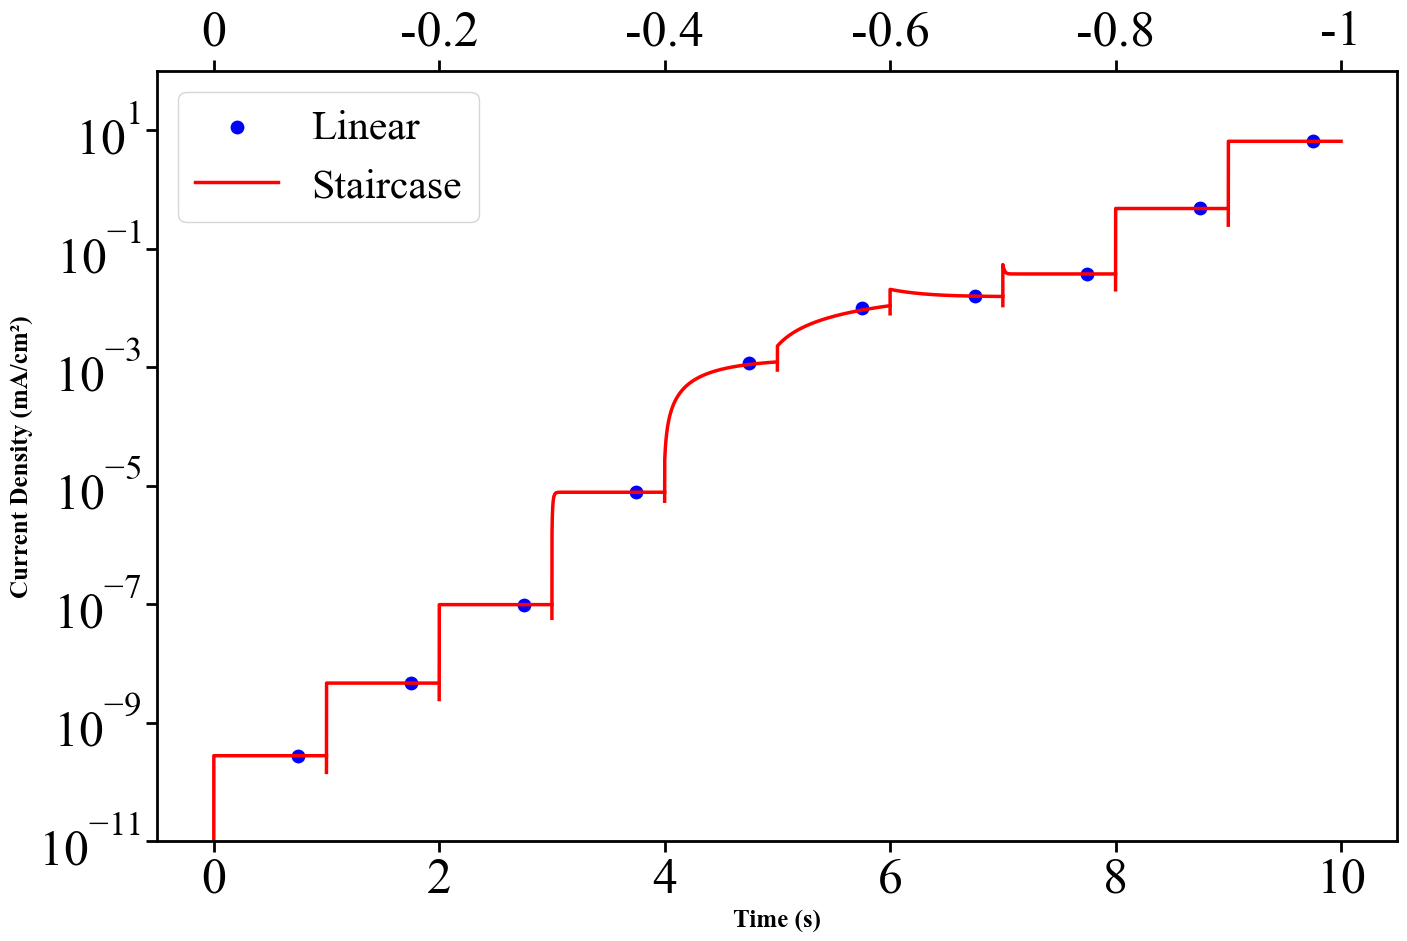

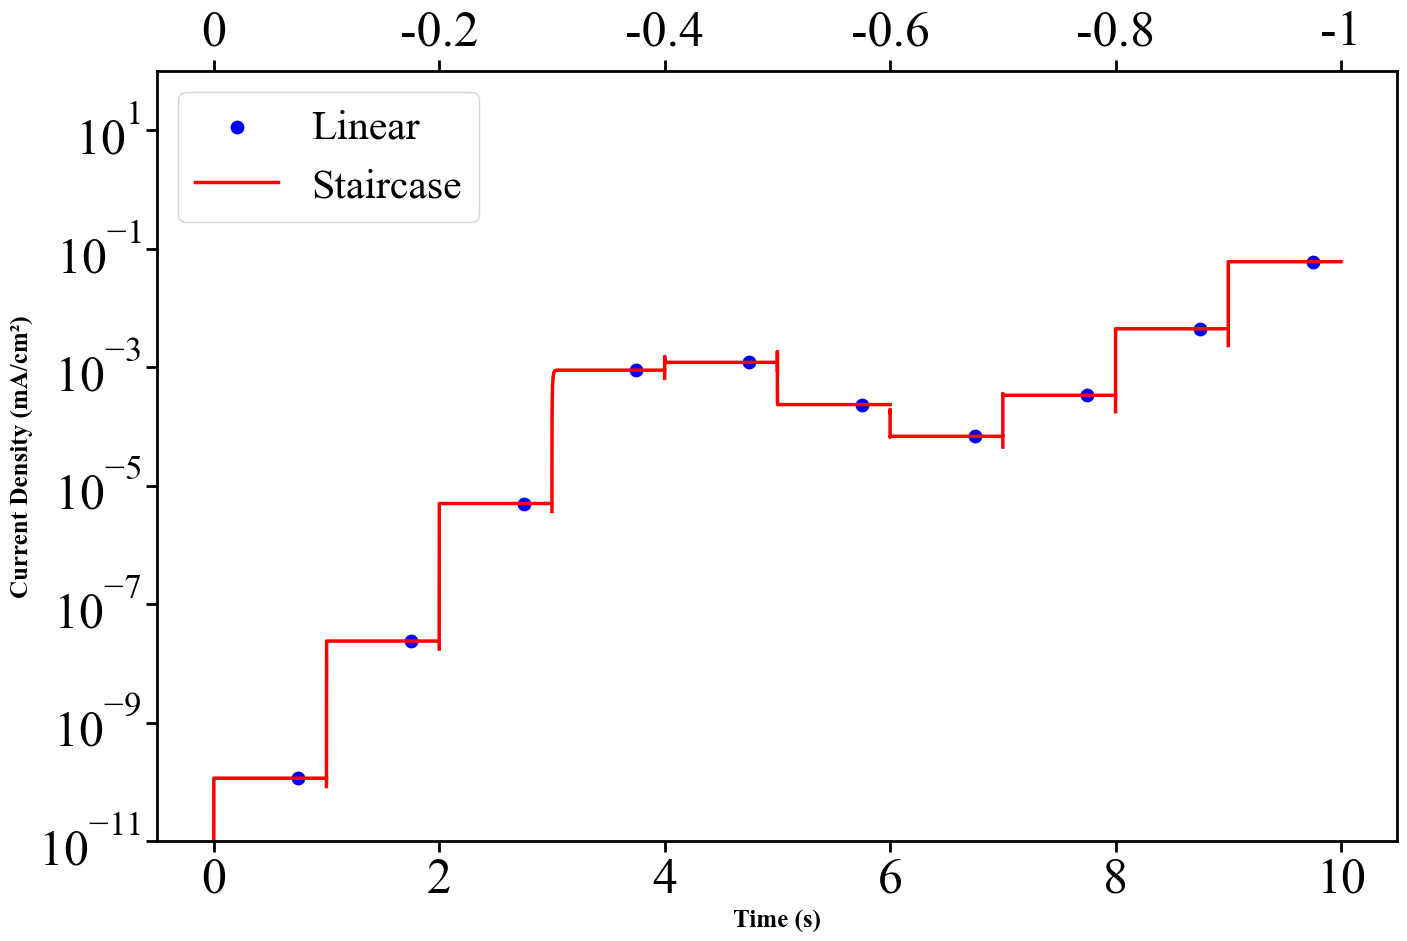

In [18]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Constants
kb = 8.617e-5   # Boltzmann constant (eV/K)
nu = 6.21e+12   # KbT/h (s^-1)
T = 298.15      # Temperature (K)
q = 1.6e-19     # Elementary charge (C)
c = 1.57e19     # site/m^2
plot_color_scatter = "blue"
plot_color_staircase = "red"

# Rate constant calculations
def calculate_rate_constants(V, pH, T):
    delg4actf = -0.1667 * (V - 0.059 * pH) + 0.4278
    delg5actf = -0.0804 * (V - 0.059 * pH) + 0.6001
    
    k4f = nu * np.exp(-delg4actf / (kb * T))
    k5f = nu * np.exp(-delg5actf / (kb * T))
    
    return k4f, k5f

# Current density calculation
def calculate_j_eth(thetah, thetacoco, thetaco, thetacho, k4f, k5f):
    return 8 * q * c * 0.1 * (
        (k5f * (thetah * thetacoco)) + 
        (k4f * (thetaco * thetacho))
    )

# Coverage data reader
def get_coverage_data(V, path):
    full_path = os.path.join(path, f"V_{V}", "run", f"{V}V")
    cov_file_path = os.path.join(full_path, "coverage.dat")
    
    if not os.path.exists(cov_file_path):
        return [], {}
    
    with open(cov_file_path) as cov_file:
        cov_lines = cov_file.readlines()
    
    time_data = []
    cov_dat_dict = {}
    adsorbate_keys = cov_lines[0].strip().split()
    
    species_of_interest = ['H*', 'COCO*', 'CO*', 'CHO*']
    for species in species_of_interest:
        if species in adsorbate_keys:
            cov_dat_dict[species] = []
    
    for line in cov_lines[1:]:
        vals = line.strip().split()
        if len(vals) == len(adsorbate_keys):
            time_data.append(float(vals[0]))
            for c, key in enumerate(adsorbate_keys):
                if key in cov_dat_dict:
                    cov_dat_dict[key].append(float(vals[c]))
    
    return time_data, cov_dat_dict

# Function to generate separate plots with secondary voltage axis
plt.rc('font', family='Times New Roman') 

# Voltage range
#V = np.linspace(0, -1, 101)  # Generate voltages from 0 to -1V with 0.01V step
V=[0,-0.01,-0.02,-0.03,-0.04,-0.05,-0.06,-0.07,-0.08,-0.09,-0.1,-0.11,-0.12,-0.13,-0.14,-0.15,-0.16,-0.17,-0.18,-0.19,-0.2,-0.21,-0.22,-0.23,-0.24,-0.25,-0.26,-0.27,-0.28,-0.29,-0.3,-0.31,-0.32,-0.33,-0.34,-0.35,-0.36,-0.37,-0.38,-0.39,-0.4,-0.41,-0.42,-0.43,-0.44,-0.45,-0.46,-0.47,-0.48,-0.49,-0.5,-0.51,-0.52,-0.53,-0.54,-0.55,-0.56,-0.57,-0.58,-0.59,-0.6,-0.61,-0.62,-0.63,-0.64,-0.65,-0.66,-0.67,-0.68,-0.69,-0.7,-0.71,-0.72,-0.73,-0.74,-0.75,-0.76,-0.77,-0.78,-0.79,-0.8,-0.81,-0.82,-0.83,-0.84,-0.85,-0.86,-0.87,-0.88,-0.89,-0.9,-0.91,-0.92,-0.93,-0.94,-0.95,-0.96,-0.97,-0.98,-0.99,-1] ##Potential with which barriers are referenced

for pH in [7, 13]:
    fig, ax = plt.subplots(figsize=(16, 10))

    cumulative_time = 0
    
    for V_val in V:
        path = os.path.join(base_directory, f"pH_{pH}")
        time_data, coverage_data = get_coverage_data(V_val, path)
        
        if not time_data:
            continue  # Skip if no data    
        
        thetah = np.array(coverage_data.get("H*", np.zeros_like(time_data)))
        thetacoco = np.array(coverage_data.get("COCO*", np.zeros_like(time_data)))
        thetaco = np.array(coverage_data.get("CO*", np.zeros_like(time_data)))
        thetacho = np.array(coverage_data.get("CHO*", np.zeros_like(time_data)))
        
        k4f, k5f = calculate_rate_constants(V_val, pH, T)
        j_eth = calculate_j_eth(thetah, thetacoco, thetaco, thetacho, k4f, k5f)

        
        # Scatter plot (blue)
        # Compute last 25% average current density
        index = [i for i, value in enumerate(time_data) if value > 0.75]
        selected_j_eth = np.average(j_eth[index]) * 1000  # Convert to mA/cm²


        if cumulative_time+0.75 < 10:
            ax.scatter(cumulative_time + 0.75, selected_j_eth,  
                        label=f'{V_val} V' if V_val == 0 else "",  
                        marker='o', s=80, color=plot_color_scatter)
            
            # Staircase plot (red)

            ax.plot(np.array(time_data) + cumulative_time, j_eth * 1000,  
                    linestyle='-', linewidth=2.5, color=plot_color_staircase)
                    

            cumulative_time += max(time_data)

    sweep_speed = os.path.basename(base_directory).split('_')[-1]

    # Primary x-axis (Time)
    ax.set_xlabel("Time (s)", fontsize=18, fontweight='bold')
    ax.set_ylabel("Current Density (mA/cm²)", fontsize=18, fontweight='bold')
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='both', width=2, length=8, labelsize=36) 

    # Add a thick border around the plot
    for spine in ax.spines.values():
        spine.set_linewidth(2)

    ax.legend(["Linear","Staircase",], loc="upper left", fontsize=30)

    #ax.set_ylim(1e-10, 1e4)

    # Secondary x-axis (Voltage)
    secax = ax.secondary_xaxis('top')
    secax.set_xlim(0, cumulative_time)  # Match primary time axis
    #secax.set_xticks(np.linspace(0, cumulative_time, 6))  # 6 evenly spaced ticks
    #secax.set_xticklabels(np.linspace(0, -1, 6))  # Corresponding voltage values
    secax.set_xticks([0,2,4,6,8,10])  # 6 evenly spaced ticks
    secax.set_xticklabels([0,-0.2,-0.4,-0.6,-0.8,-1])  # Corresponding voltage values
    secax.tick_params(axis='x',width=2, length=8, labelsize=36)
    plt.ylim(1e-11, 1e2)
    #ax.set_box_aspect(0.55)


    # Show each figure separately
    plt.show()


# Define the base directory where the data is stored
base_directory = r"D:\projects\new_calculation\corr\sweeping\USS_CV\CORR\sweep_speed_100mV"

## Different scan rates

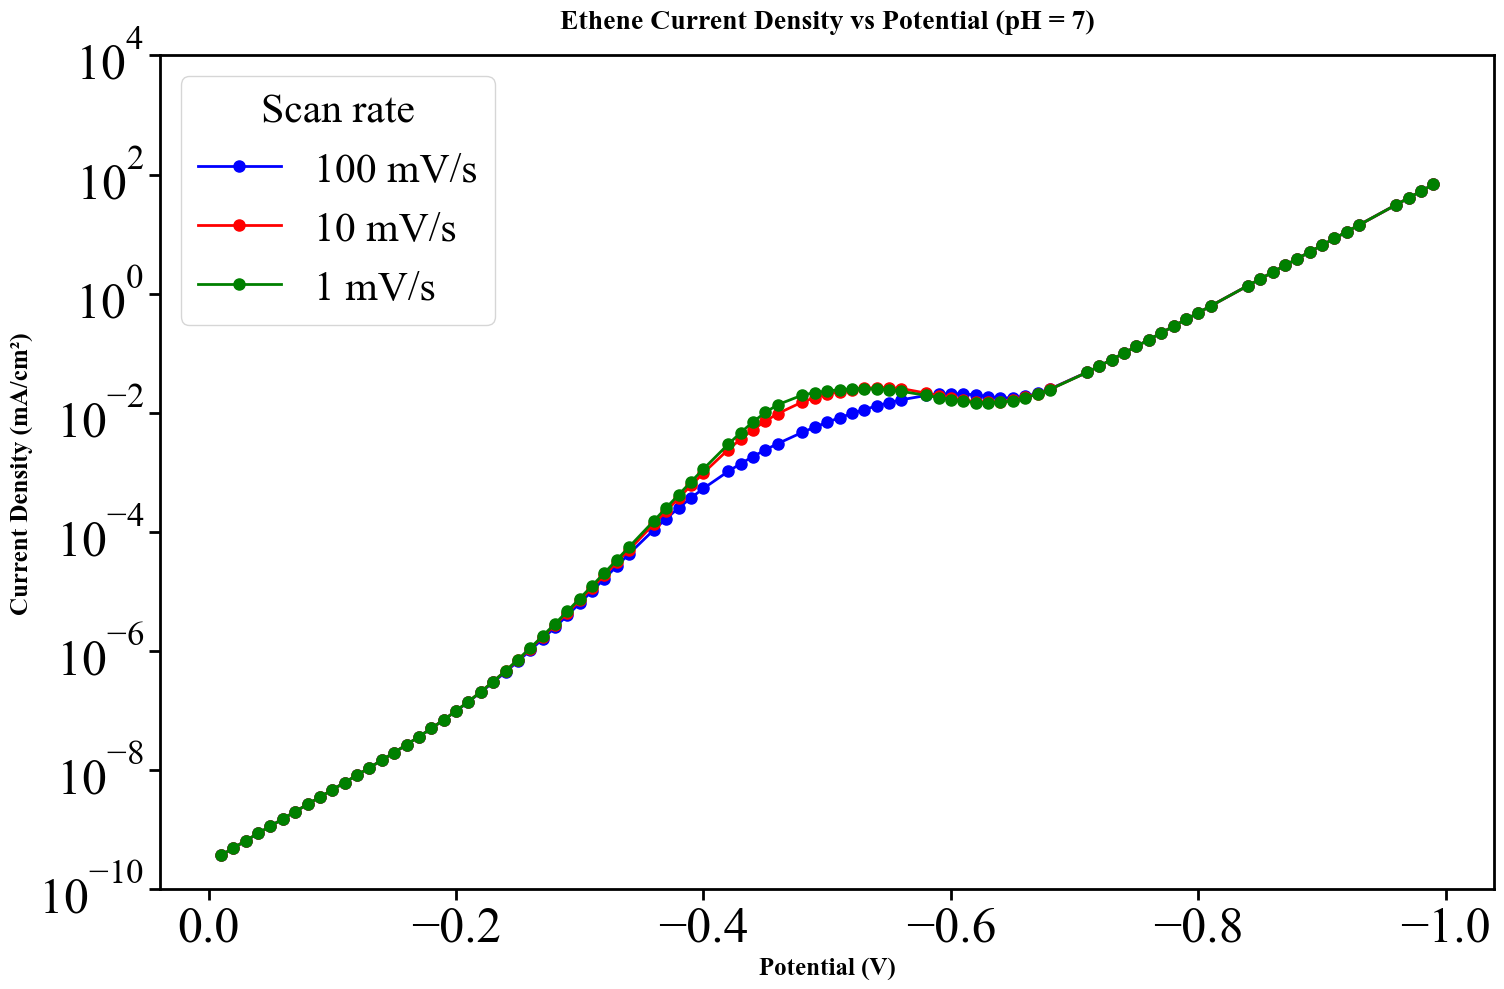

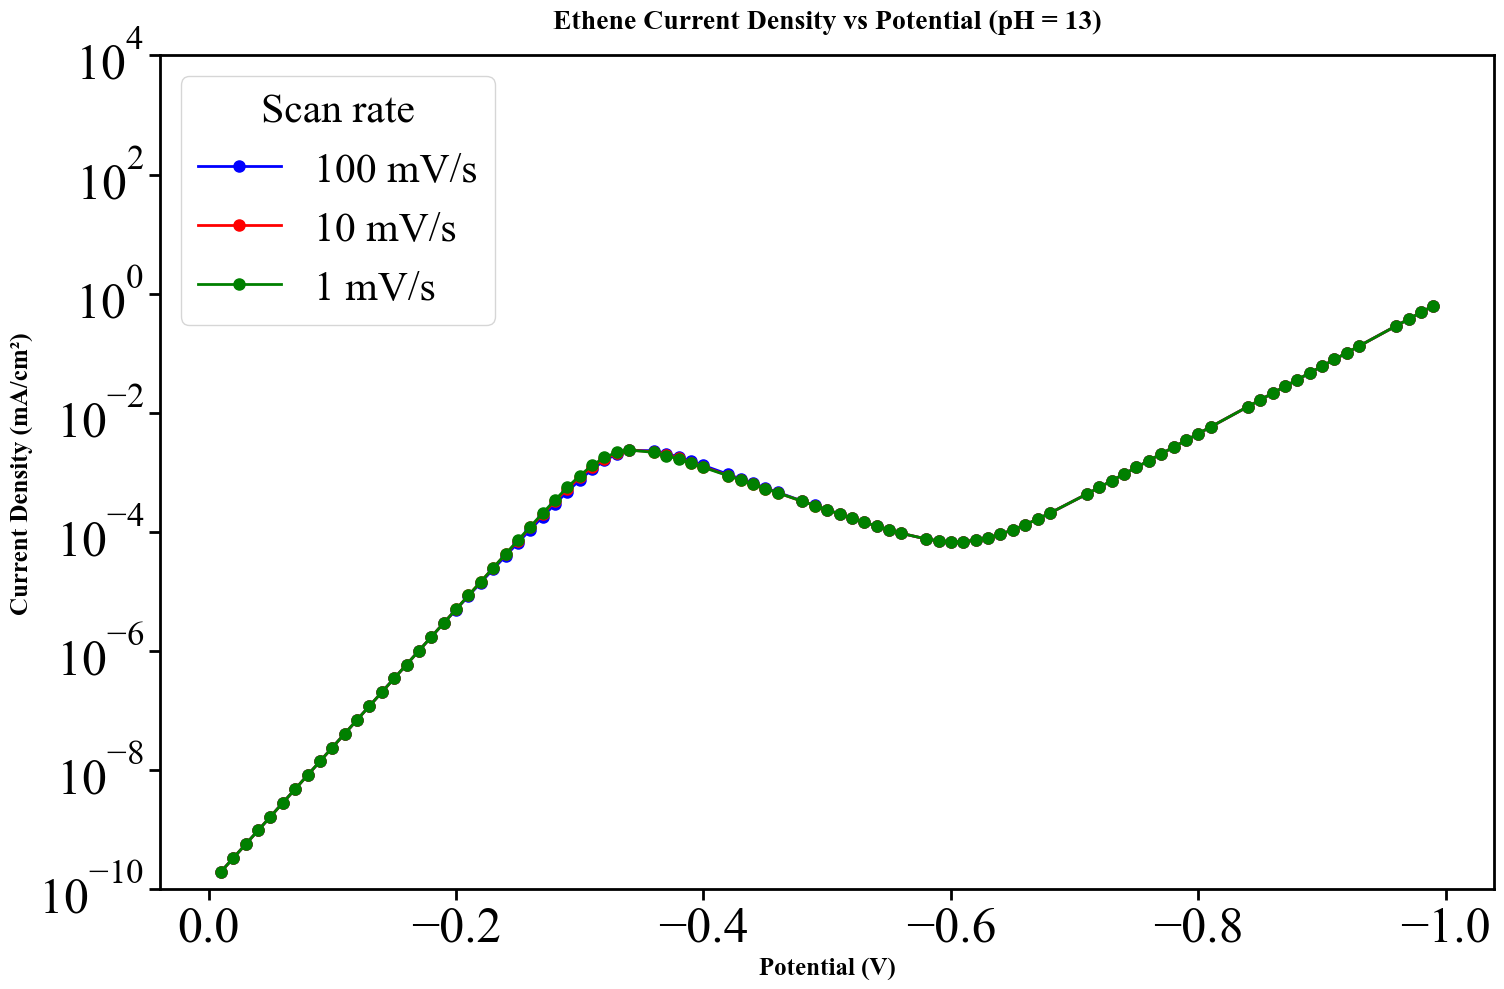

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Constants
kb = 8.617e-5   # Boltzmann constant (eV/K)
nu = 6.21e+12   # KbT/h (s^-1)
T = 298.15      # Temperature (K)
q = 1.6e-19     # Elementary charge (C)
c = 1.57e19    # site/m^2

# Voltage range
V = np.linspace(0, -1, 101)  # 101 points from 0V to -1V

# Rate constant calculations
def calculate_rate_constants(V, pH, T):
    delg4actf = -0.1667 * (V - 0.059 * pH) + 0.4278
    delg5actf = -0.0804 * (V - 0.059 * pH) + 0.6001
    k4f = nu * np.exp(-delg4actf / (kb * T))
    k5f = nu * np.exp(-delg5actf / (kb * T))
    return k4f, k5f

# Current density calculation
def calculate_j_eth(thetah, thetacoco, thetaco, thetacho, k4f, k5f):
    return 8 * q * c * 0.1 * ((k5f * (thetah * thetacoco)) + (k4f * (thetaco * thetacho)))

# Coverage data reader
def get_coverage_data(V, path):
    full_path = os.path.join(path, f"V_{V}", "run", f"{V}V")
    cov_file_path = os.path.join(full_path, "coverage.dat")
    
    if not os.path.exists(cov_file_path):
        return [], {}

    with open(cov_file_path) as cov_file:
        cov_lines = cov_file.readlines()
    
    time_data = []
    cov_dat_dict = {}
    adsorbate_keys = cov_lines[0].strip().split()
    
    for species in ['H*', 'COCO*', 'CO*', 'CHO*']:
        if species in adsorbate_keys:
            cov_dat_dict[species] = []
    
    for line in cov_lines[1:]:
        vals = line.strip().split()
        if len(vals) == len(adsorbate_keys):
            time_data.append(float(vals[0]))
            for c, key in enumerate(adsorbate_keys):
                if key in cov_dat_dict:
                    cov_dat_dict[key].append(float(vals[c]))

    return time_data, cov_dat_dict

# Function to plot current density vs potential
def generate_plots(ax, base_directory, label, color, pH):
    voltage_values = []
    current_densities = []
    
    for V_val in V:
        path = os.path.join(base_directory, f"pH_{pH}")
        time_data, coverage_data = get_coverage_data(V_val, path)
        
        if not time_data:
            continue  # Skip if no data

        # Select a single representative time point (middle index)

       
        #mid_index = len(time_data) // 2  
        
        thetah = np.array(coverage_data.get("H*", np.zeros_like(time_data)))
        thetacoco = np.array(coverage_data.get("COCO*", np.zeros_like(time_data)))
        thetaco = np.array(coverage_data.get("CO*", np.zeros_like(time_data)))
        thetacho = np.array(coverage_data.get("CHO*", np.zeros_like(time_data)))
        
        k4f, k5f = calculate_rate_constants(V_val, pH, T)
        j_eth = calculate_j_eth(thetah, thetacoco, thetaco, thetacho, k4f, k5f)
        
        #selected_j_eth = j_eth[mid_index] * 1000  # Convert to mA/cm²

         # Select the last 25% of the time steps
        last_25_percent_index = int(0.75 * len(time_data))  # Start index for the last 25%
        j_eth_last_25 = j_eth[last_25_percent_index:]  # Extract last 25% of j_eth values

        average_j_eth_last_25 = np.mean(j_eth_last_25) * 1000  # Convert to mA/cm²
        
        voltage_values.append(V_val)
        #current_densities.append(selected_j_eth)
        current_densities.append( average_j_eth_last_25)


    # Plot the current density vs potential
    ax.plot(voltage_values, current_densities,  
            label=label,  
            marker='o', linestyle='-',  
            markersize=8, linewidth=2,  
            color=color)

# Base directories for different sweep speeds
base_directory_100mV = r"D:\projects\new_calculation\corr\sweeping\USS_CV\CORR\sweep_speed_100mV_100_points"
base_directory_10mV = r"D:\projects\new_calculation\corr\sweeping\USS_CV\CORR\sweep_speed_10mV_100_points"
base_directory_1mV = r"D:\projects\new_calculation\corr\sweeping\USS_CV\CORR\sweep_speed_1mV_100points"

# Separate plots for each pH
for pH in [7, 13]:
    fig, ax = plt.subplots(figsize=(16, 10))
    plt.rc('font', family='Times New Roman')  # Set global font to Times New Roman


    # Overlay plots from all three sweep speeds
    generate_plots(ax, base_directory_100mV, label="100 mV/s", color="blue", pH=pH)
    generate_plots(ax, base_directory_10mV, label="10 mV/s", color="red", pH=pH)
    generate_plots(ax, base_directory_1mV, label="1 mV/s", color="green", pH=pH)

    # Formatting
    ax.set_xlabel("Potential (V)", fontsize=18, fontweight='bold')
    ax.set_ylabel("Current Density (mA/cm²)", fontsize=18, fontweight='bold')
    ax.set_title(f"Ethene Current Density vs Potential (pH = {pH})", fontsize=20, pad=20, fontweight='bold')
    ax.set_yscale('log')
    ax.legend(fontsize=30, title="Scan rate", title_fontsize=30, loc='upper left')
    ax.tick_params(axis='both', which='both', width=2, length=8, labelsize=36)
    plt.ylim(1e-10, 1e4) 
    plt.rc('font', family='Times New Roman')  # Set global font to Times New Roman

    # make y axis log
    
    ax.set_box_aspect(0.625)

    


    # Invert x-axis
    plt.gca().invert_xaxis()

    # Add a thick border around the plot
    for spine in ax.spines.values():
        spine.set_linewidth(2)

    plt.tight_layout()
    plt.show()

## Steady State Plots

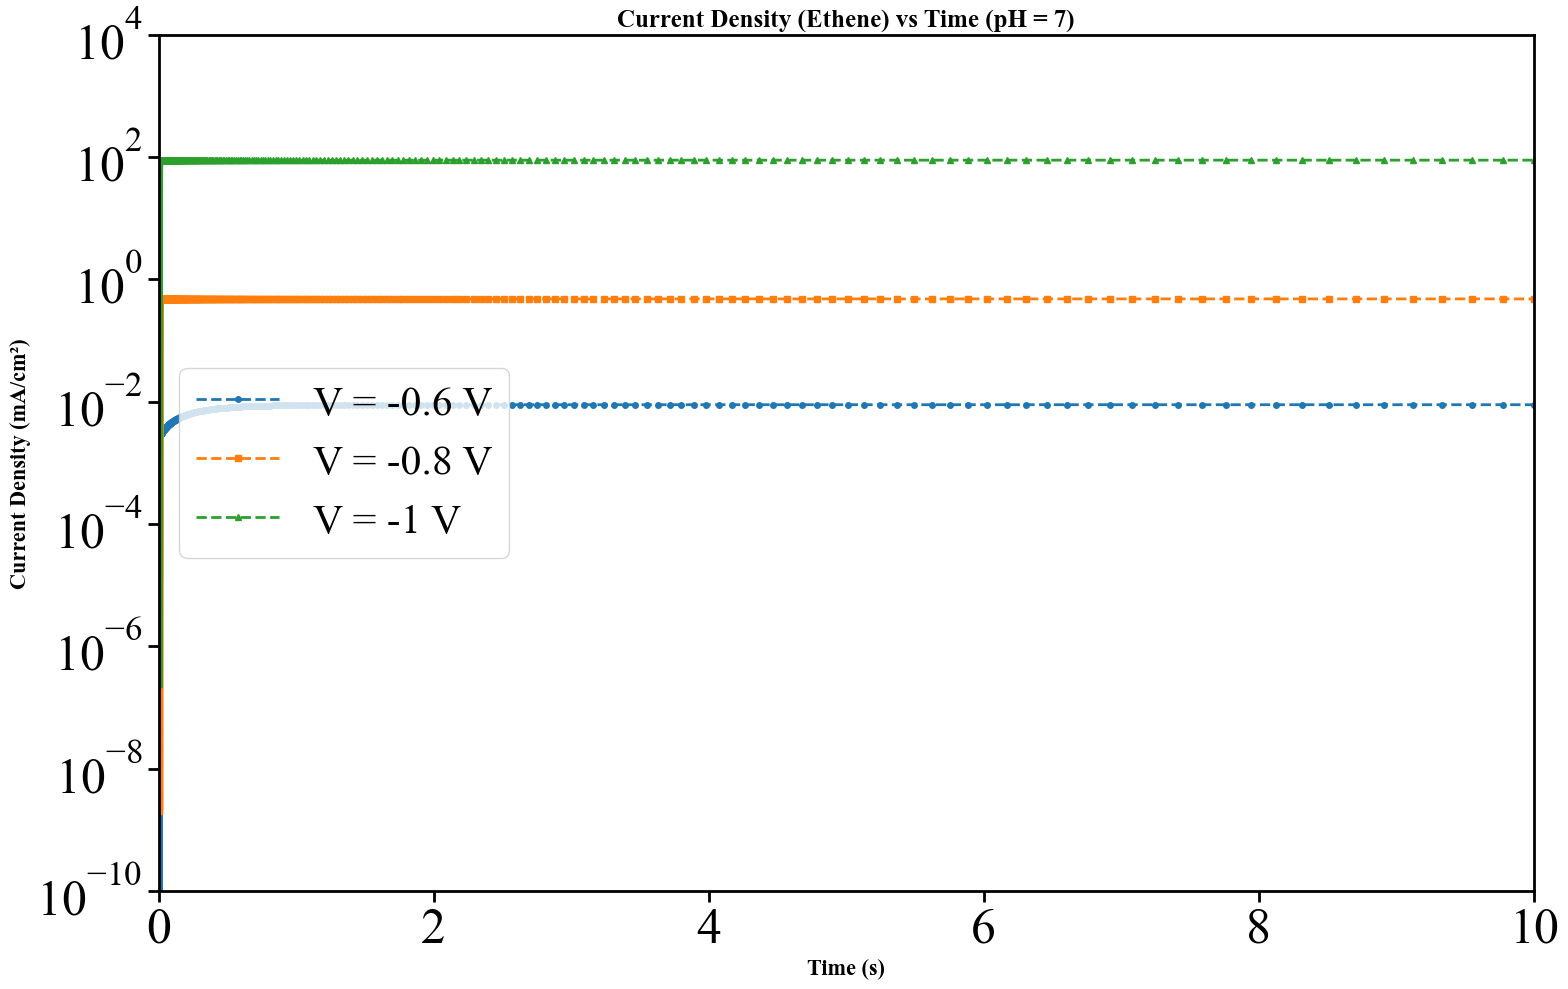

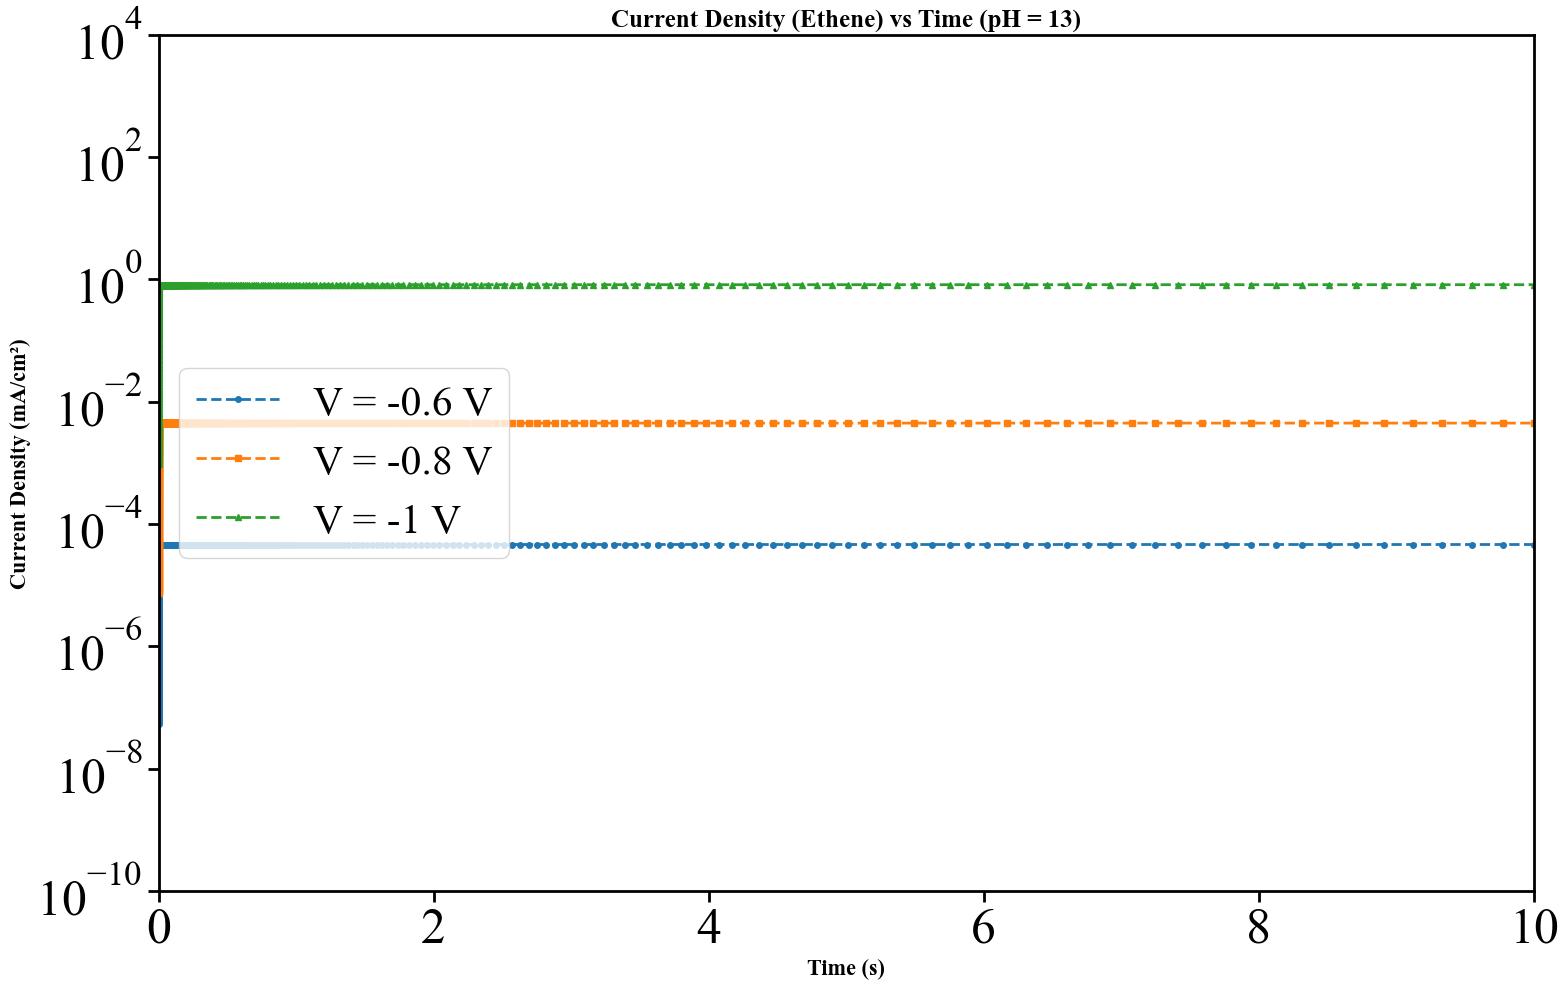

In [24]:
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter

# Constants provided
kb = 8.617e-5  # Boltzmann constant (eV/K)
nu = 6.21e+12  # KbT/h (s^-1)
T = 298.15     # temperature (K)
q = 1.6e-19    # Elementary charge (C)
k = 6.026e23
c = 1.57e19    # site/m^2   # Avogadro's constant
sco = 1        # stoichiometric factor for CO
scho = 1       # stoichiometric factor for CHO
sh = 1         # stoichiometric factor for H
scoco = 2      # stoichiometric factor for COCO

# Define the Gibbs free energy change for activation for both reactions
def calculate_rate_constants(V, pH, T):
    delg4actf = -0.1667 * (V - 0.059 * pH) + 0.4278
    delg5actf = -0.0804 * (V - 0.059 * pH) + 0.6001
    
    k4f = nu * np.exp(-delg4actf / (kb * T))  # Forward rate constant for reaction 4
    k5f = nu * np.exp(-delg5actf / (kb * T))  # Forward rate constant for reaction 5
    
    return k4f, k5f

# Helper function to calculate j_eth (current density) for each potential
def calculate_j_eth(thetah, thetacoco, thetaco, thetacho, k4f, k5f):
    return 8 * q * c * 0.1 * (
        ((k5f * (thetah * thetacoco)) / (sco * scoco)) +
        ((k4f * (thetaco * thetacho)) / (sco * scho))
    )

# Function to read coverage data
def get_coverage_data(V, path):
    path = os.path.join(path, f"V_{V}", "run", f"{V}V")  # Adjusted path to 'range'
    cov_file = open(os.path.join(path, "coverage.dat"))
    cov_lines = cov_file.readlines()
    cov_file.close()
    
    time_data = []
    cov_dat_dict = {}

    # Read the coverage data
    adsorbate_keys = cov_lines[0].strip().split()  # This extracts the column headers
        
    # Initialize dictionary with the species that are of interest (dynamically)
    species_of_interest = ['H*', 'COCO*', 'CO*', 'CHO*', "H2O*", "*"]
    
    for species in species_of_interest:
        if species in adsorbate_keys:  # Only initialize species that exist in the file
            cov_dat_dict[species] = []
        else:
            print(f"Warning: Species {species} not found in coverage data.")

    # Extract time and coverage data for each species
    for line in cov_lines[1:]:
        vals = line.strip().split()
        
        # Ensure there is enough data in the line
        if len(vals) == len(adsorbate_keys):  # +1 for the time value
            time_data.append(float(vals[0]))  # Time is the first value
            for c, key in enumerate(adsorbate_keys):
                if key in cov_dat_dict:  # Only store coverage data for species we care about
                    cov_dat_dict[key].append(float(vals[c]))  # Coverage data for each species
    
    return time_data, cov_dat_dict

# Define species of interest
species_of_interest = 'CO*'

# Choose distinct colors and markers for each potential
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'deepskyblue']
markers = ['o', 's', '^', 'D', 'P', 'H', 'X', 'v', '<', '>', '1']  # Different markers for each potential

# Function to generate plots based on the base directory and pH
def generate_plots(base_directory):
    plt.rc('font', family='Times New Roman')  # Set global font to Times New Roman

    V=[0,-0.1,-0.2,-0.3,-0.4,-0.5,-0.6,-0.7,-0.8,-0.9,-1] ##Potential with which barriers are referenced
    species_of_interest = 'CO*'

    # Create separate plots for pH = 7 and pH = 13
    for pH in [7, 13]:
        # Create a separate figure for each pH
        fig, ax = plt.subplots(figsize=(16, 10))

        # Loop through different potentials (V values)
        k=0
        for i, V_val in enumerate(V):
            path1 = "pH_" + str(pH)
            path = os.path.join(base_directory, path1)

            # Get time and coverage data for the current potential and pH
            time_data, coverage_data = get_coverage_data(V_val, path)

            if species_of_interest in coverage_data:  # Check if species is present in the data
                # Extract coverage values for the species
                thetah = np.array(coverage_data.get("H*", [0] * len(time_data)))  # Default to 0 if not found
                thetacoco = np.array(coverage_data.get("COCO*", [0] * len(time_data)))  # Default to 0 if not found
                thetaco = np.array(coverage_data.get("CO*", [0] * len(time_data)))  # Default to 0 if not found
                thetacho = np.array(coverage_data.get("CHO*", [0] * len(time_data)))  # Default to 0 if not found

                # Calculate rate constants for this potential
                k4f, k5f = calculate_rate_constants(V_val, pH, T)

                # Calculate j_eth (current density) for each time step
                j_eth = calculate_j_eth(thetah, thetacoco, thetaco, thetacho, k4f, k5f)

                # Ensure that j_eth and time_data have the same length
                if len(j_eth) == len(time_data):
                    # Plot j_eth vs time with different color and marker for each V
                    if V_val == -1 or V_val == -0.8 or V_val == -0.6 :
                        
                        ax.plot(time_data, j_eth*1000, label=f'V = {V_val} V',color=colors[k], markersize=4,marker=markers[k], linestyle='--', linewidth=2)
                        k=k+1
                else:
                    print(f"Warning: Mismatch in lengths for V = {V_val}")

        # Extract the sweep speed by splitting the directory name
        directory_name = os.path.basename(base_directory)
        sweep_speed = directory_name.split('_')[-1]

        # Set labels and title with bold font and increased font size
        ax.set_xlabel("Time (s)", fontsize=16, fontweight='bold')
        ax.set_ylabel(f"Current Density (mA/cm²)", fontsize=16, fontweight='bold')
        ax.set_title(f"Current Density (Ethene) vs Time (pH = {pH})", fontsize=18, fontweight='bold')

        # Set both axes to logarithmic scale
        ax.set_yscale('log')

        # Set the x-axis and y-axis tick formatting to scientific notation

        # Add a legend with bold font and increased font size
        ax.legend(loc='center left', prop={'size':30}, frameon=True)

        # Make the tick marks bold and thicker
        #ax.tick_params(axis='both', which='both', width=5, length=15, labelsize=30)
        plt.rc('font', family='Times New Roman')  # Set global font to Times New Roman
        ax.tick_params(axis='both', which='both', width=2, length=8, labelsize=36) 


        # Add a thick border around the plot
        for spine in ax.spines.values():
            spine.set_linewidth(2)

        plt.xlim(0,10)   
        plt.ylim(1e-10, 1e4) 
        ax.set_box_aspect(0.622665)



        plt.tight_layout()
        plt.show()

# Specify your base directory here
base_directory = r"D:\projects\new_calculation\corr\sweeping\USS_CV\CORR\Steady_state"
generate_plots(base_directory)